In [157]:
##################
#TREINO DO MODELO:
##################

# Se estiver usando o Ipython/Jupyter notebook:
import matplotlib.pyplot as plt
%matplotlib inline
import os
folder = '../../../dados/resultados_teste_tcu/' # Inserir aqui a pasta local do repositorio:
#os.chdir(folder)
from funcoes import * # Importa funcoes

In [2]:
cols_mostrar = ['DS_ITEM_CLEAN','SG_UNIDADE_MEDIDA','QT_ITENS','ITEM_VL_UNITARIO_HOMOLOGADO']

# PARAMETROS:
tamanho_minimo_pra_formar_grupo = 30
qtd_palavras = 16
qtd_dimensoes = 300
qtd_dimensoes_umap = 15
quantile_a_retirar_outliers_dbscan = 0.95
minimo_cosine_similarity = 0.9
qtd_ngram_FastText = 3
cv_maximo_pra_considerar_grupo_homogeneo_sentenca = 1.75
percentual_primeira_palavra_igual_pra_considerar_grupo_homogeneo = 0.50
percentual_pra_manter_palavra_na_representacao = 0.50
qtd_min_auditadas_para_formar_grupo = 10
quantile_a_retirar_numeros_diferentes_no_grupo = 0.95
quantile_a_retirar_quantidade_palavras_diferentes_no_grupo = 0.95

# Descobre arquivos de dados:
#pasta = './data/'
#arquivos = descobre_arquivos_na_pasta(pasta,tipo_do_arquivo='.xlsx')
#arquivos.remove('Tabelas Auxiliares.xlsx')

In [3]:
file1 = '../../../dados/itens_pregao_pitem_saude.csv'
print(file1)
#items = get_items(file1)
licitacon = pd.read_csv(file1,sep=';')
licitacon = licitacon.sample(frac=0.2)
licitacon.head()#,licitacon.shape

../../../dados/itens_pregao_pitem_saude.csv


,seq_dim_licitacao,num_exercicio,nom_entidade,seq_dim_item,nom_item,dsc_unidade_medida,nom_item_busca,vlr_quantidade,vlr_unitario_homologado,nom_funcao,vlr_licitacao
299445,1058521,2016,Fruta de Leite,34012689,CARRINHO DE MAO,UNIDADE,CARRINHO DE MAO,4.0,110.000,Saúde,118397.15
270968,1021938,2015,Capitólio,31004155,FARINHA DE MANDIOCA,KILO,FARINHA DE MANDIOCA,75.0,2.440,Saúde,50391.23
165065,1013331,2015,Cabo Verde,30437989,NIMESULIDA 50MG/ML,VIDRO,NIMESULIDA 50MG/ML,6000.0,0.845,Saúde,1208033.14
1381911,1162448,2018,Paraguaçu,41596605,"Lixeira pequena ( nao telada), de plastico, se...",UN,"LIXEIRA PEQUENA ( NAO TELADA), DE PLASTICO, SE...",12.0,3.920,Saúde,260501.92
853268,1112069,2018,Salinas,37720767,CENTRAL DE NEBULIZAÇÃO COM 4 SAÍDAS POTÊNCIA M...,UNIDADE,CENTRAL DE NEBULIZACAO COM 4 SAIDAS POTÊNCIA M...,1.0,1242.000,Saúde,40693.90


### Preprocessamento samuel

In [4]:
# licitacon['unid_proc'] = list(map(lambda x : preprocess_document(x, remove_numbers=False,stopwords=None)
#                                      , licitacon['dsc_unidade_medida'].astype(str)))
# licitacon['desc_proc'] = list(map(lambda x : preprocess_document(x, remove_numbers=False,stopwords=None)
#                                      , licitacon['nom_item_busca'].astype(str)))
# licitacon['desc_token'] = licitacon['desc_proc'].apply(tokenize_document)                        
# licitacon[['nom_item','desc_proc','desc_token','unid_proc']]


### Primeira etapa de pre processamento e limpeza

In [5]:
#pra fazer download dos corpus/stopwords:
#nltk.download()
#nltk.download('punkt')

# stopwords sao somente punctuation. O resto DEIXO, tem palavras importantes pros produtos: com/sem/tem/nem, etc.
stopwords = set(list(punctuation))

unidades = ['x','mm','m','cm','ml','g','mg','kg','unidade','unidades'
            ,'polegada','polegadas','grama','gramas','gb','mb','l','litro','litros'
            ,'mts','un','mgml','w','hz','v','gr','lt','lts','lonas','cores','mcg']

primeira_palavra_generica = ['caixa','jogo','kit','conjunto','item','it','cjt','conj'
                             ,'conjt','jg','kt','de','para']

#limpa sentencas retirando stopwords (tem que ser minusculo) e pontuacao.
licitacon['DS_ITEM_CLEAN'] = [ ' '.join([word for word in item.split() \
                                         if word.lower() not in stopwords]) \
                              for item in licitacon['nom_item'].astype(str) ]
#insere espaco apos / e -, pra no final nao ficar palavras assim: 
#csolucao, ptexto (originais eram c/solucao, p-texto)
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply( \
                                            lambda x: re.sub(r'/|-',r' ',x))
#retira pontuacao, /, etc:
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply( \
                        lambda x: x.translate(str.maketrans('', '', string.punctuation)))
#passa pra minusculo:
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: x.lower())
#insere espaco apos numero e letra (separa unidades de medida:) 
#ex.: 500ml vs 100ml vs 500mg
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: re.sub(r'(\d{1})(\D)',r'\1 \2',x))
#insere espaco apos letra e numero ex.:c100 pc50
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: re.sub(r'(\D{1})(\d)',r'\1 \2',x))
#retira espacos duplicados
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: re.sub(r' +',r' ',x))
#retira acentos:
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: unidecode.unidecode(x))

licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: ' '.join(x.split()[1:] + [x.split()[0]]) if ((len(x) > 1) and (x.split()[0].isdigit()) ) else x)
# remove zeros a esquerda de numeros (02 litros, 05, etc.)
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: ' '.join([word.lstrip('0') for word in x.split()] ) )
# remove 'x', pra não diferenciar pneu 275 80 de 275 x 80:
licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(lambda x: ' '.join([word for word in x.split() if word is not 'x']))

#retira primeira palavra se estah em unidades ou primeira_palavra_generica:
# roda varias vezes pra tirar todas as primeiras palavras:
for _ in range(3):
    licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(
        lambda x: ' '.join(x.split()[1:]) \
        if (len(x) > 1 \
            and (x.split()[0] in unidades \
            or x.split()[0] in primeira_palavra_generica)) else x )

In [6]:
licitacon[['nom_item','DS_ITEM_CLEAN']] 

,nom_item,DS_ITEM_CLEAN
299445,CARRINHO DE MAO,carrinho de mao
270968,FARINHA DE MANDIOCA,farinha de mandioca
165065,NIMESULIDA 50MG/ML,nimesulida 50 mg ml
1381911,"Lixeira pequena ( nao telada), de plastico, se...",lixeira pequena nao telada de plastico sem tam...
853268,CENTRAL DE NEBULIZAÇÃO COM 4 SAÍDAS POTÊNCIA M...,central de nebulizacao com 4 saidas potencia m...
...,...,...
86962,Ezetimiba 10 mg-317180,ezetimiba 10 mg 317180
235792,TANQUE DE COMBUSTIVEL*-,tanque de combustivel
922808,MOLA 4 DIANT/TRAS.ONIBUS MB,mola 4 diant trasonibus mb
222589,TUBO 40 MM ESGOTO SECUNDARIO:,tubo 40 mm esgoto secundario


### Segunda etapa de limpeza

In [7]:
#mostra registros aleatorios:
# df['DS_ITEM_CLEAN'].iloc[np.random.randint(len(df),size=50)]

#a partir de agora filtra soh pra material de consumo OU Equipamentos e Material Permanente:
df = licitacon.copy()
#df = df[df['NATUREZA_DESPESA'].apply(lambda x: x.endswith('30') or x.endswith('52'))]
licitacon['dsc_unidade_medida'] = map(str.lower, licitacon['dsc_unidade_medida'])

df = df[~((licitacon['dsc_unidade_medida'].str.contains('serv')) 
                            | (licitacon['DS_ITEM_CLEAN'].str.contains('serv'))
                            | (licitacon['DS_ITEM_CLEAN'].str.contains('prest')))]



# retira livros:
df = df[df['DS_ITEM_CLEAN'].apply(lambda x: 'livro' not in x)]
df.shape,licitacon.shape

((343593, 12), (345726, 12))

#### Treinamento de word embeddings

In [8]:
#limito a 16 palavras - pega 85% dos itens até 16 palavras, o resto é lixo
#, tem item com mais de 300 palavras.
sentences = [sent.split()[:qtd_palavras] for sent in df['DS_ITEM_CLEAN']]
# exploracao/descobre se tem palavra:
# guindaste = df['DS_ITEM_CLEAN'].str.contains('guindaste', regex=False)
# guindastes = df['DS_ITEM_CLEAN'].loc[guindaste[guindaste == True].index]
# guindastes.to_csv(folder+'guindastes.csv')
print('Treino word2vec/fastText word embeddings gensim:')
model = FastText(sentences,size=qtd_dimensoes
                 , min_count=tamanho_minimo_pra_formar_grupo, workers=4
                 , min_n=qtd_ngram_FastText, max_n=qtd_ngram_FastText, iter=10)

Treino word2vec/fastText word embeddings gensim:


#### Atribuicao de pesos e normalizacao da base de embeddings

In [9]:
import pdb
# grava(coisa=model,filename='model_20190826.pkl',path=folder)
# grava_arquivo_grande(coisa=model,filename='model_20190728.pkl',path=folder)

print('Conversao word embeddings to sentence embedding, com pesos:')
doc_vectors = {}
for number, sent in enumerate(sentences):
    # dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    #pdb.set_trace()
    if len(sent) == 0:
        doc_vectors[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors[number] = model[sent[0]]
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos # agora com pesos 1/x - tem que ser na ordem 1,2,..., os menores numeros dao maiores pesos - decai menos que exponencial, que eh muito brusca a queda.
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            #pdb.set_trace()
            if word.isdigit():
                #nova abordagem: se eh digit, atribui peso NO 3/4 da 
                #faixa entre o peso da primeira e da ultima palavra. 
                #Mesmo peso pra todos os numeros, mais importante que palavras do fim, 
                #menos importante que palavras do inicio.
                media.append(model.wv[word] * ((pesos[0]+pesos[-1])*(1/4)) )                 
                divisao += ((pesos[0]+pesos[-1])*(1/4))
            else:
                media.append(model.wv[word] * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors[number] = np.array(media).sum(axis=0) / divisao #media de tudo

doc_vectors = DataFrame(doc_vectors).T
doc_vectors = doc_vectors.set_index(df.index) # coloca o ID_ITEM como index:

Conversao word embeddings to sentence embedding, com pesos:


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [156]:
doc_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
299445,-0.240913,0.605518,0.550123,1.024041,0.093197,0.574037,-0.105019,-0.052065,1.143474,0.686219,...,-0.504882,-0.049156,0.358699,0.579658,0.255574,0.067725,0.172588,-0.969270,0.486779,0.352649
270968,0.585693,0.501867,-0.135173,1.323993,-1.021825,-0.208879,-0.071450,0.030417,0.178289,-0.306000,...,0.703424,-0.727780,1.715189,0.619498,0.186961,-1.095520,0.079721,-0.042713,0.424178,0.354084
165065,0.753183,0.577477,-0.795919,-0.676803,0.578511,-0.406572,-0.381959,-0.408078,-0.152143,-0.257030,...,0.215213,-0.184067,0.816043,0.183118,-0.498086,-0.089508,0.112554,0.118346,0.239770,0.280955
1381911,0.280276,-0.000086,0.526745,0.600130,-0.083426,0.354245,-0.061110,0.115531,-0.005161,0.715196,...,0.672344,0.049608,0.255161,-0.086345,-0.240218,0.134947,0.171956,0.083188,0.219043,-0.241473
853268,0.244818,0.558339,0.635965,0.316632,-0.578992,-0.878380,-0.186696,0.083297,-0.308959,0.033749,...,0.427364,0.372032,0.227312,0.517027,-0.051864,-0.168263,-0.002119,-0.101332,-0.570555,0.234945


In [155]:
np.array(range(10)) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
print('StandardScaler:')
scaler = StandardScaler()
doc_vectors_std_df = DataFrame(scaler.fit_transform(doc_vectors)
                               ,index=doc_vectors.index,columns=doc_vectors.columns)

StandardScaler:


### Executa reducao de dimensionalidade

In [11]:
# descobrir quais as maiores quantidades de finais de natureza de despesa:
# df['final'] = df['NATUREZA_DESPESA'].apply(lambda x: x[-2:])
# df.groupby('final')['DS_ITEM_CLEAN'].count().sort_values(ascending=False)

# Reduz dims com UMAP - DEMORA - Reduz pra 15 dimns com UMAP direto das 300 dimns, sem PCA:
print('Reduz com UMAP pra', str(qtd_dimensoes_umap),'dimensoes.')
# agora com metric = 'cosine'. desempenho colocando init='random' piora, mas eh mais rapido.
umap_redux = abre(filename='umap_redux_20200819.pkl', path=folder)

#umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap
#                       , random_state=999, metric='cosine',verbose=True)
#umap_redux.fit(doc_vectors_std_df) 


# soh material de consumo: 16h / 
#soh nao material de consumo: 16h / 
#material de consumo + equipamentos e material permantente (853 mil rows): 23h. 
#nova extracao 906 mil linhas (mat consumo, permanente, equipamentos): 31h
#mas deu warning: WARNING: spectral initialisation failed! 
#The eigenvector solver failed. This is likely due to too small an eigengap. 
#nova extracao v8 licitacon mat consumo/permanente/equipamentos (919 mil linhas): 38h.


Reduz com UMAP pra 15 dimensoes.
UMAP(angular_rp_forest=True, metric='cosine', n_components=15, random_state=999,
     verbose=True)
Construct fuzzy simplicial set
Wed Aug 19 19:31:02 2020 Finding Nearest Neighbors
Wed Aug 19 19:31:02 2020 Building RP forest with 34 trees
Wed Aug 19 19:32:18 2020 NN descent for 18 iterations
	 0  /  18
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
Wed Aug 19 19:34:02 2020 Finished Nearest Neighbor Search
Wed Aug 19 19:34:15 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Aug 19 19:58:29 2020 Finished embedding


UMAP(angular_rp_forest=True, metric='cosine', n_components=15, random_state=999,
     verbose=True)

In [12]:
# umap_redux = abre(filename='umap_redux_20190820.pkl', path=folder)
#umap_redux = abre(filename='umap_redux_20190823.pkl', path=folder)
#grava(coisa=umap_redux,filename='umap_redux_20200819.pkl', path=folder)
# grava(coisa=umap_redux,filename='umap_redux_20190826.pkl', path=folder)

doc_vectors_std_df_umap = umap_redux.transform(X=doc_vectors_std_df)

### Inicio da clusterizacao

#### Executa HDBScan

In [13]:
# HDBSCAN clustering:
import time
print('Clusterizando, tamanho minimo pra formar grupo:', str(tamanho_minimo_pra_formar_grupo))
min_samples = 1

t0 = time.time()
clustering = hdbscan.HDBSCAN(min_cluster_size=tamanho_minimo_pra_formar_grupo
                             ,min_samples=min_samples
                             ,prediction_data=True
                             ,core_dist_n_jobs=-1)
clustering.fit(doc_vectors_std_df_umap)
print("Tempo: ",time.time-t0)

df['grupo'] = clustering.labels_

Clusterizando, tamanho minimo pra formar grupo: 30


In [163]:
len(clustering.labels_)

343593

In [162]:
from collections import Counter

Counter(clustering.labels_)

Counter({1267: 109,
         1553: 70,
         295: 84,
         1646: 128,
         2173: 74,
         3559: 31,
         1355: 118,
         -1: 59930,
         3111: 189,
         919: 39,
         3072: 130,
         2129: 178,
         2931: 77,
         1345: 643,
         1349: 1017,
         2446: 51,
         792: 57,
         613: 293,
         162: 51,
         2132: 323,
         1208: 198,
         2585: 66,
         151: 44,
         2049: 307,
         3420: 146,
         2104: 61,
         1948: 55,
         1855: 37,
         1868: 807,
         1503: 46,
         775: 30,
         3331: 98,
         1465: 48,
         2911: 186,
         2399: 89,
         2714: 211,
         3351: 51,
         2610: 88,
         283: 56,
         423: 494,
         3145: 156,
         361: 47,
         442: 220,
         1189: 37,
         1101: 206,
         1354: 110,
         528: 205,
         2770: 85,
         3388: 191,
         197: 64,
         312: 83,
         412: 60,
  

#### Remove outliers

In [172]:
# atribui -2 aos outliers pelo HDBSCAN:
threshold = pd.Series(clustering.outlier_scores_).quantile(
    quantile_a_retirar_outliers_dbscan)
outliers = np.where(clustering.outlier_scores_ > threshold)[0]
df.iloc[outliers,df.columns.get_loc('grupo')] = -2
#SAMUELchecar quais sao esses outliers

grupos = np.unique(clustering.labels_)
grupos = [grupo for grupo in grupos if grupo >= 0]
#print_exemplos_grupos(df=df,inicio=1000,fim=1050,grupos=grupos,grupox='grupo',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
#print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo')

In [57]:
#hdbscan.validity.all_points_mutual_reachability(doc_vectors_std_df_umap
#                                                , clustering.labels_
#                                               ,1,metric='euclidean',d=2)

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/hdbscan/validity.py:31: RuntimeWarning: overflow encountered in power
  distance_matrix != 0]) ** d


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05788058,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01904918, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00359174, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [76]:
# id = 10
# clustering.labels_[clustering.labels_ == id].shape,\
# doc_vectors_std_df_umap[clustering.labels_ == id].shape,\
# df[df.grupo == id].shape


((76,), (76, 15), (63, 13))

#### checando a distribuição de distancia interna dos clusters

In [173]:
from itertools import combinations
from sklearn.metrics import pairwise_distances

def dist_interna(X, cluster_obj, cluster_id, metric="euclidean"):
    
    cluster_instances = X[(cluster_obj.labels_ == cluster_id) 
                          & (cluster_obj.outlier_scores_ <= threshold) ]
    
    if cluster_instances.shape[0] > 0:
        pairwise_mat = pairwise_distances(cluster_instances,metric=metric)
        pairwise = [pairwise_mat[x][y] for x,y in combinations(range(len(cluster_instances)),2)]
        return cluster_id,np.mean(pairwise),np.std(pairwise)
    else:
        return cluster_id,-1,-1
    
#filter_cluster = lambda c_id : doc_vectors_std_df_umap[(clustering.labels_ == c_id) 
#                        & (clustering.outlier_scores_ <= threshold)]    
    
    
distances = [dist_interna(doc_vectors_std_df_umap,clustering, x) \
             for x in tqdm(range(len(set(clustering.labels_))))]

#distances
#cols = ['grupo',"nom_item","num_exercicio",'vlr_unitario_homologado'
#        ,'dsc_unidade_medida']
#df[df.grupo == 1][cols].head(50)





  0%|          | 0/3608 [00:00<?, ?it/s]



  1%|▏         | 53/3608 [00:00<00:06, 521.97it/s]



  3%|▎         | 102/3608 [00:00<00:06, 509.71it/s]



  4%|▎         | 134/3608 [00:00<00:08, 429.82it/s]



  4%|▍         | 162/3608 [00:00<00:09, 358.07it/s]



  6%|▌         | 201/3608 [00:00<00:09, 365.58it/s]



  7%|▋         | 239/3608 [00:00<00:09, 368.64it/s]



  8%|▊         | 276/3608 [00:00<00:09, 364.60it/s]



  9%|▉         | 317/3608 [00:00<00:08, 376.88it/s]



 10%|▉         | 354/3608 [00:00<00:08, 373.92it/s]



 11%|█         | 390/3608 [00:01<00:09, 337.70it/s]



 12%|█▏        | 424/3608 [00:01<00:12, 264.18it/s]



 13%|█▎        | 454/3608 [00:01<00:11, 273.79it/s]



 13%|█▎        | 485/3608 [00:01<00:17, 177.23it/s]



 14%|█▍        | 519/3608 [00:01<00:15, 203.42it/s]



 15%|█▌        | 553/3608 [00:01<00:13, 228.07it/s]



 16%|█▌        | 581/3608 [00:02<00:15, 193.84it/s]



 17%|█▋        | 610/3608 [00:02<00:13, 215.23it/s]



 18%|█▊        | 6

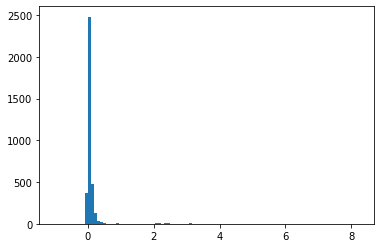

In [165]:
aux = [y for x,y,z in distances]
xx = plt.hist(aux, bins = 100)

In [166]:
ids_dist_alta = [x for x,y,_ in distances if y > 2]
len(ids_dist_alta)

59

In [167]:
ids_dist_alta

[3,
 11,
 15,
 17,
 49,
 152,
 229,
 248,
 256,
 259,
 295,
 297,
 298,
 308,
 310,
 314,
 315,
 344,
 356,
 414,
 426,
 472,
 489,
 519,
 559,
 568,
 607,
 680,
 695,
 736,
 886,
 966,
 967,
 976,
 995,
 1011,
 1019,
 1142,
 1159,
 1177,
 1204,
 1230,
 1308,
 1354,
 1357,
 1400,
 1464,
 1664,
 1667,
 1807,
 1885,
 1910,
 2009,
 2257,
 2270,
 2351,
 2359,
 2448,
 2505]

In [180]:
# print(distances[ids_dist_alta[10]])
x = 501#ids_dist_alta[3]
print(distances[x])
df[df.grupo == x][cols].head(60)

(501, 0.009402822, 0.010063804)


,grupo,nom_item,num_exercicio,vlr_unitario_homologado,dsc_unidade_medida
1087541,501,LEVOTIROXINA SODICA 25 MCG COMPRIMIDO,2015,0.0900,UN
1338002,501,LEVOTIROXINA SODICA 25MCG COMP.,2016,0.0510,UNIDADE
630286,501,Levotiroxina sodica 25mcg comprimido,2015,0.1160,UN
1434244,501,Levotiroxina sodica 25 MCG - comprimido,2017,0.0970,UNIDADE
509736,501,"2017 - Levotiroxina Sódica, Comprimido, 25 mcg",2017,0.1500,UN
982845,501,031179 LEVOTIROXINA SODICA 25 MCG COMPRIMIDO,2017,0.0900,UNIDADE
733665,501,LEVOTIROXINA SODICA 25 MCG COMP,2017,0.0850,UNIDADE
527302,501,LEVOTIROXINA SÓDICA 25 MCG COMPRIMIDO,2016,0.1500,UNID
738256,501,LEVOTIROXINA SODICA 25MCG COMPRIMIDO,2016,4000.0000,CP
1120566,501,LEVOTIROXINA SODICA 25MCG COMP.,2017,0.0730,UNIDADE


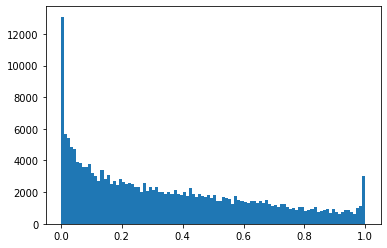

In [26]:
#O que exatamente significa essa variavel clustering.outlier_scores_ 
#https://hdbscan.readthedocs.io/en/latest/outlier_detection.html
#The hdbscan library supports the GLOSH outlier detection algorithm, 
#and does so within the HDBSCAN clustering class
#o algoritmo citado anteriormente serve para detectar outliers locais e globais

plt.hist(clustering.outlier_scores_[clustering.outlier_scores_ > 0], bins = 100)
plt.show()

In [ ]:
#########################################
# EXCLUI sentences outliers pelo texto pelos exemplars - DEMORA
# FAZ cosine distance pra cada sentence dentro dos grupos
#########################################

print('EXCLUI sentences outliers pelo texto pelos exemplars:')

#pontos mais representativos de cada grupo (como hdbscan aceita formato aleatorio de cada cluster, nao tem como passar/nao existe um centroide, como no k-means, que assume grupos esfericos)
exemplars = []
for exemplar in tqdm(clustering.exemplars_):
    exemplars.append(np.mean(exemplar,axis=0))
exemplars_df = DataFrame(exemplars,index=range(len(grupos)))

map_grupos_exemplars = {}
df_temp = DataFrame(columns=['sims'])

for grupo in tqdm(grupos[:]):

    df2 = df[df['grupo'] == grupo]
    indexes = df2.index
    grupo_vectors = DataFrame(doc_vectors_std_df_umap,index=df.index).loc[indexes]
    
    grupo_do_exemplar = Series(cosine_similarity(grupo_vectors.mean(axis=0).values.reshape(1,-1),exemplars_df)[0]).sort_values(ascending=False).index[0]
    map_grupos_exemplars[grupo] = grupo_do_exemplar

    sims = cosine_similarity(grupo_vectors,exemplars[grupo_do_exemplar].reshape(1,-1))

    df2['sims'] = sims
    df_temp = df_temp.append(df2[['sims']])

#passa resultados pro df principal:
df['sims'] = df_temp
df['sims'] = df['sims'].replace(np.nan,-1)

#retira quem tem similaridade negativa - eh um bom parametro.
df['grupo2'] = np.where(df['sims'] < 0, -1, df['grupo'])

grupos = df['grupo2'].unique()
grupos = [grupo for grupo in grupos if grupo >= 0]

# print_exemplos_grupos(df=df,inicio=1500,fim=1600,grupos=grupos,grupox='grupo2',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo2')

#######################
# Reduzi um passo aqui:
df['grupo3'] = df['grupo2']
#######################

##########################################
# Se a 1a palavra nao for a mesma em X% do grupo, exclui o grupo, eh muito heterogeneo: - eh RAPIDO
##########################################

print('Se a 1a palavra nao for a mesma em X% do grupo, exclui o grupo, eh muito heterogeneo:')

grupos = sorted(df['grupo3'].unique())
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

grupos_homogeneos = []

for grupo in tqdm(grupos):
    df2 = df[df['grupo3'] == grupo]
    if len(df2) > 0:
        if ( df2['DS_ITEM_CLEAN'].apply(lambda x: x.split()[0] if (len(x.split()) > 0) else np.random.random()).value_counts().iloc[0] / len(df2) ) > percentual_primeira_palavra_igual_pra_considerar_grupo_homogeneo:
            grupos_homogeneos.append(grupo)

df['grupo4'] = df['grupo3'].isin(grupos_homogeneos)
df['grupo4'] = np.where(df['grupo4'], df['grupo3'], -1)

grupos = sorted(df['grupo4'].unique())
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

# print_exemplos_grupos(df=df,inicio=1500,fim=1600,grupos=grupos,grupox='grupo4',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo4')

############################################################################
# EXCLUI GRUPOS NAO HOMOGENEOS - pela contagem de palavras diferentes! - eh RAPIDO
############################################################################

df['qtd_palavras_diferentes'] = df['DS_ITEM_CLEAN'].apply(lambda x: len(set( [item for sublist in [sent.split()[:qtd_palavras] for sent in x] for item in sublist    ] ) ))
qtd_palavras_por_grupo = df.groupby('grupo4')['qtd_palavras_diferentes'].median()
qtd_palavras_por_grupo = qtd_palavras_por_grupo.sort_values()
qtd_max_palavras_diferentes_no_grupo = int(qtd_palavras_por_grupo.quantile(quantile_a_retirar_quantidade_palavras_diferentes_no_grupo))
print('Quantidade maxima de palavras diferentes aceita por grupo:', qtd_max_palavras_diferentes_no_grupo)

df['qtd_median_palavras_dif_grupo'] = df['grupo4'].map(qtd_palavras_por_grupo)

df['grupo5'] = np.where(df['qtd_median_palavras_dif_grupo'] > qtd_max_palavras_diferentes_no_grupo, -1, df['grupo4'])

grupos = df['grupo5'].unique()
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

# print_exemplos_grupos(df=df,inicio=1500,fim=1600,grupos=grupos,grupox='grupo5',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo5')

############################################################################
# EXCLUI GRUPOS que tem items SOMENTE DE UMA MESMA AUDITADA - sao escritos muito especificos, queremos coisas compradas por varias auditadas. - eh RAPIDO
############################################################################

qtd_auditadas_por_grupo = df.groupby(['grupo5'])['NOME'].apply(lambda x: len(np.unique(x)) )
df['qtd_auditadas_diferentes_do_grupo'] = df['grupo5'].map(qtd_auditadas_por_grupo)
df['grupo6'] = np.where(df['qtd_auditadas_diferentes_do_grupo'] > qtd_min_auditadas_para_formar_grupo, df['grupo5'], -1)

grupos = df['grupo6'].unique()
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

# print_exemplos_grupos(df=df,inicio=1500,fim=1600,grupos=grupos,grupox='grupo6',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo6')

############################################################################
# EXCLUI GRUPOS que tem MUITOS NUMEROS DIFERENTES NAS SENTENCES: - RAPIDO 
############################################################################

df['qtd_numeros_diferentes'] = df['DS_ITEM_CLEAN'].apply(lambda x: len(set( [item for sublist in [sent.split()[:qtd_palavras] for sent in x] for item in sublist if item.isdigit()   ] ) ))
df['qtd_numeros_diferentes'] = np.where(df['qtd_numeros_diferentes'] == 0, 0, df['qtd_numeros_diferentes']-1)
qtd_numeros_por_grupo = df.groupby('grupo4')['qtd_numeros_diferentes'].median()
qtd_numeros_por_grupo = qtd_numeros_por_grupo[qtd_numeros_por_grupo > 0]
qtd_numeros_por_grupo = qtd_numeros_por_grupo.sort_values()
qtd_max_numeros_diferentes_no_grupo = int(qtd_numeros_por_grupo.quantile(quantile_a_retirar_numeros_diferentes_no_grupo))
print('Quantidade maxima de numeros diferentes aceita por grupo:', qtd_max_numeros_diferentes_no_grupo)

df['qtd_median_numeros_dif_grupo'] = df['grupo4'].map(qtd_numeros_por_grupo)

df['grupo7'] = np.where(df['qtd_median_numeros_dif_grupo'] > qtd_max_numeros_diferentes_no_grupo, -1, df['grupo6'])

grupos = df['grupo7'].unique()
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

# print_exemplos_grupos(df=df,inicio=1500,fim=1600,grupos=grupos,grupox='grupo7',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo7')

###########################
# passo reduzido:
###########################

df['grupo8'] = df['grupo7']

###########################
print('Conversao word embeddings to sentence embedding, com pesos:')
###########################

model2 = Word2Vec(sentences,size=qtd_dimensoes, min_count=1,workers=-1)

doc_vectors2 = {}

for number, sent in enumerate(tqdm(sentences)):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors2[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors2[number] = model2.wv[sent[0]]
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos # agora com pesos 1/x - tem que ser na ordem 1,2,..., os menores numeros dao maiores pesos - decai menos que exponencial, que eh muito brusca a queda.
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            # media.append(model2.wv[word])
            # divisao += 1
            ######### AGORA O MODEL EH W2V E O PESO EH DOBRADO PRA DIGITS:
            if word.isdigit():
                media.append(model2.wv[word] * ((pesos[0]+pesos[-1])*(1/2)) )
                divisao += ((pesos[0]+pesos[-1])*(1/2))
            else:
                media.append(model2.wv[word] * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors2[number] = np.array(media).sum(axis=0) / divisao #media de tudo

doc_vectors2 = DataFrame(doc_vectors2).T
doc_vectors2 = doc_vectors2.set_index(df.index)

doc_vectors_grupos = {}

for grupo in tqdm(grupos):
    indices = df[df['grupo8'] == grupo].index
    doc_vectors_grupos[grupo] = doc_vectors2.loc[indices]
    doc_vectors_grupos[grupo] = doc_vectors_grupos[grupo].mean(axis=0)

doc_vectors_grupos = DataFrame(doc_vectors_grupos).T

##########
#usa o scaler original:
doc_vectors_grupos_std = DataFrame(scaler.transform(doc_vectors_grupos),index=doc_vectors_grupos.index,columns=doc_vectors_grupos.columns)

grupos_similarities = cosine_similarity(doc_vectors_grupos_std)

grupos_similarities = DataFrame(grupos_similarities,index=doc_vectors_grupos.index,columns=doc_vectors_grupos.index)

similarity_minima_pra_juntar_grupos = 0.90

#junta os grupos:
grupos_similares = []
for grupo in tqdm(grupos_similarities):
    agrupar_df = grupos_similarities[grupo].sort_values(ascending=False)
    agrupar_df = agrupar_df[agrupar_df >= similarity_minima_pra_juntar_grupos]
    grupos_similares.append(list(agrupar_df.index))

novo_grupo = 0
mapeamento_grupos = {}
for mini_grupo in tqdm(grupos_similares):
    if len(mini_grupo) == 1:
        mapeamento_grupos[mini_grupo[0]] = novo_grupo
    else:
        for grupo in mini_grupo:
            if grupo not in mapeamento_grupos.keys():
                for mini_grupo2 in grupos_similares:
                    if grupo in mini_grupo2:
                        mapeamento_grupos[grupo] = novo_grupo
                        for grupo2 in mini_grupo2:
                            if grupo2 not in mapeamento_grupos.keys():
                                mapeamento_grupos[grupo2] = novo_grupo
    novo_grupo += 1

df['grupo9'] = df['grupo8'].map(mapeamento_grupos)
df['grupo9'] = df['grupo9'].fillna(-1)
df['grupo9'] = df['grupo9'].astype(int)

grupos = df['grupo9'].unique()
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

# print_exemplos_grupos(df=df,inicio=1500,fim=1600,grupos=grupos,grupox='grupo9',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_exemplos_grupos_v2_aleatorio(df=df,qtd_grupos_mostrar=10,grupos=grupos,grupox='grupo9',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo9')

###############################################
# Agora repassar as sentences do grupo -1 e tentar encaixá-las nos grupos formados, só com grande certeza. - Demora 5 min.
###############################################

excluidos_index =  df[df['grupo9'] == -1].index
incluidos_index =  df[df['grupo9'] >= 0].index

doc_vectors_excluidos = doc_vectors.loc[excluidos_index]
doc_vectors_incluidos = doc_vectors.loc[incluidos_index]

doc_vectors_grupos_finais = {}
for grupo in tqdm(grupos):
    df2 = df[df['grupo9'] == grupo]
    # doc_vectors_grupos_finais[grupo] = doc_vectors_std.loc[df2.index].mean()
    # doc_vectors_grupos_finais[grupo] = DataFrame(doc_vectors_std_pca_umap,index=doc_vectors_std.index).loc[df2.index].mean()
    doc_vectors_grupos_finais[grupo] = doc_vectors_incluidos.loc[df2.index]
    doc_vectors_grupos_finais[grupo] = doc_vectors_grupos_finais[grupo].values.mean(axis=0)
# index aqui jah eh o numero certo dos grupos:
doc_vectors_grupos_finais = DataFrame(doc_vectors_grupos_finais).T

compara = cosine_similarity(doc_vectors_excluidos.loc[excluidos_index],doc_vectors_grupos_finais.values)
compara = DataFrame(compara,index=excluidos_index, columns=grupos)
similarity_do_grupo_mais_parecido = compara.max(axis=1)
grupo_mais_parecido = compara.idxmax(axis=1)

similarity_minima_pra_encaixar_itens_excluidos_no_final = 0.95

encaixar_excluidos = Series( np.where(similarity_do_grupo_mais_parecido >= similarity_minima_pra_encaixar_itens_excluidos_no_final, grupo_mais_parecido, -1), index= similarity_do_grupo_mais_parecido.index)
df['grupo10'] = encaixar_excluidos
df['grupo10'] = df['grupo10'].fillna(-1)
df['grupo10'] = np.where(df['grupo10'] == -1, df['grupo9'], df['grupo10'])

grupos = df['grupo10'].unique()
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

# print_exemplos_grupos(df=df,inicio=1500,fim=1600,grupos=grupos,grupox='grupo10',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_exemplos_grupos_v2_aleatorio(df=df,qtd_grupos_mostrar=10,grupos=grupos,grupox='grupo10',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=df,grupos=grupos,grupox='grupo10')

grava(coisa=doc_vectors_grupos_finais,filename='doc_vectors_grupos_finais_20190823v3.pkl',path=folder)

###############################################
# Agora repassa todas os registros do LICITACON que nao foram usados (outros que nao natureza_despesa de material de consumo) e tenta encaixa-los
###############################################

#jah foram tentados todos do df, os que foram classificados e os que nao deu, ficaram -1 mesmo.
registros_a_tentar_classificar = [i for i in licitacon.index if i not in df.index]

df2 = licitacon.loc[registros_a_tentar_classificar]

sentences2 = [sent.split()[:qtd_palavras] for sent in df2['DS_ITEM_CLEAN']]

print('Conversao word embeddings to sentence embedding, com pesos:')
doc_vectors2 = {}
#Here the magic happens:
for number, sent in enumerate(tqdm(sentences2)):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors2[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors2[number] = model.wv[sent[0]]
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos # agora com pesos 1/x - tem que ser na ordem 1,2,..., os menores numeros dao maiores pesos - decai menos que exponencial, que eh muito brusca a queda.
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            if word.isdigit():
                media.append(model.wv[word] * ((pesos[0]+pesos[-1])*(1/4)) ) #nova abordagem: se eh digit, atribui peso NO 3/4 da faixa entre o peso da primeira e da ultima palavra. Mesmo peso pra todos os numeros, mais importante que palavras do fim, menos importante que palavras do inicio.
                divisao += ((pesos[0]+pesos[-1])*(1/4))
            else:
                media.append(model.wv[word] * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors2[number] = np.array(media).sum(axis=0) / divisao #media de tudo

doc_vectors2 = DataFrame(doc_vectors2).T
doc_vectors2 = doc_vectors2.set_index(df2.index) # coloca o ID_ITEM como index:

# faz por partes pra nao dar memory error:
qtd_chunks = 10
similarity_do_grupo_mais_parecido_final = Series()
grupo_mais_parecido_final = Series()

for df_splited in tqdm(np.array_split(doc_vectors2, qtd_chunks)):

    compara = cosine_similarity(df_splited.values,doc_vectors_grupos_finais.values)
    compara = DataFrame(compara,index=df_splited.index, columns=doc_vectors_grupos_finais.index)

    similarity_do_grupo_mais_parecido = compara.max(axis=1)
    grupo_mais_parecido = compara.idxmax(axis=1)

    similarity_do_grupo_mais_parecido_final = similarity_do_grupo_mais_parecido_final.append(similarity_do_grupo_mais_parecido)
    grupo_mais_parecido_final = grupo_mais_parecido_final.append(grupo_mais_parecido)

# -2 sao os que nao foram encaixados, mas vao ser treinados no proximo umap:
# -1 continua sendo os que passaram pelo processo mas nao foram classificados como material de consumo
encaixar_excluidos = Series( np.where(similarity_do_grupo_mais_parecido_final >= similarity_minima_pra_encaixar_itens_excluidos_no_final, grupo_mais_parecido_final, -2), index= similarity_do_grupo_mais_parecido_final.index)

#encaixa todos os results do material de expediente no licitacon:
classificacoes_final = encaixar_excluidos.append(df['grupo10'])
licitacon['grupo10'] = classificacoes_final

grupos = licitacon['grupo10'].unique()
grupos = [grupo for grupo in grupos if grupo >=0] #tirar os -1, -2, etc.

print_exemplos_grupos_v2_aleatorio(df=licitacon,qtd_grupos_mostrar=10,grupos=grupos,grupox='grupo10',cols=cols_mostrar+['NOME'],qtd_palavras=qtd_palavras,percentual_pra_manter_palavra_na_representacao=percentual_pra_manter_palavra_na_representacao,unidades=unidades)
print_qtd_grupos_sentencas_uteis(df=licitacon,grupos=grupos,grupox='grupo10')

# grava(coisa=licitacon,filename='licitacon_20190826.pkl',path=folder)
grava(coisa=licitacon,filename='licitacon_20190823v3.pkl',path=folder)

In [8]:
import os
a = '../dados/outliers_from_hdbscan_emb50_samp100_size30_dimfull.csv'
os.path.basename(a)

'outliers_from_hdbscan_emb50_samp100_size30_dimfull.csv'